**Installation of related liberary**

In [ ]:
!pip install pandas imbalanced-learn

**Preparing data for processing and oversampling**

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from google.colab import files

**Load the original dataset and check for missing values**

In [ ]:
# Load the dataset
uploaded = files.upload()
data = pd.read_csv('/content/ad_performance_no_outliers_.csv')

# Drop any rows with missing values to ensure clean data
data = data.dropna()

Saving ad_performance_no_outliers_.csv to ad_performance_no_outliers_.csv


**Clean and format the three numeric fields uv, ocr, and search in the dataset, and print out the original category distributions for the several categorical fields**

In [ ]:
# Ensure 'uv', 'ocr', and 'search' are numeric, non-negative, and rounded to 4 decimal places
for col in ['uv', 'ocr', 'search']:
    data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert to numeric, invalid entries become NaN
    data[col] = data[col].clip(lower=0)                    # Clip negative values to 0
    data[col] = data[col].round(4)                         # Round to 4 decimal places

# Drop any rows with missing values
data = data.dropna()

# Print original class distributions of key categorical features
print("\nOriginal distribution:")
print("Payment:", Counter(data['payment']))
print("Material:", Counter(data['material']))
print("Sellingpoint:", Counter(data['sellingpoint']))
print("Placement:", Counter(data['placement']))



Original distribution:
Payment: Counter({'cpc': 396, 'roi': 174, 'cpm': 38, 'cpd': 17})
Material: Counter({'jpg': 403, 'swf': 219, 'gif': 3})
Sellingpoint: Counter({'Price Drop': 264, 'Discount': 143, 'Spend & Save': 107, 'Cash/Coupon-Back': 47, 'Gift with Purchase': 34, 'Flash Sale': 30})
Placement: Counter({'sub-banner': 281, 'uncertained': 208, 'banner': 99, 'tips': 37})


**for subsequent SMOTE; then automatically set reasonable k_neighbors based on the number of samples in the largest category**

In [ ]:
# Define target sample size based on the largest class among all categorical features
target_counts = max(data['payment'].value_counts().max(),
                    data['material'].value_counts().max(),
                    data['sellingpoint'].value_counts().max(),
                    data['placement'].value_counts().max())

# Function: Dynamically determine k_neighbors for SMOTE based on the minority class size
def get_k_neighbors(y, default_k=3):
    minority_count = min(Counter(y).values())
    return min(default_k, max(1, minority_count - 1))



Oversampling and balancing of the “sellingpoint” field in the ad data to address category imbalances

In [ ]:
# 1. Balance the 'sellingpoint' feature using SMOTE

# Encode the target variable 'sellingpoint'
le_sellingpoint = LabelEncoder()
data['sellingpoint_encoded'] = le_sellingpoint.fit_transform(data['sellingpoint'])

# Define feature set X and target y
X = data[['uv', 'ocr', 'search', 'payment', 'material', 'placement']]
y = data['sellingpoint_encoded']

# Encode categorical features in X
le_payment = LabelEncoder()
le_material = LabelEncoder()
le_placement = LabelEncoder()
X['payment'] = le_payment.fit_transform(X['payment'])
X['material'] = le_material.fit_transform(X['material'])
X['placement'] = le_placement.fit_transform(X['placement'])

# Dynamically determine a suitable k_neighbors value
k_neighbors = get_k_neighbors(y, default_k=3)

# Apply SMOTE to balance the 'sellingpoint' classes
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=k_neighbors)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Reconstruct resampled dataset
data_resampled = X_resampled.copy()
data_resampled['sellingpoint'] = le_sellingpoint.inverse_transform(y_resampled)
data_resampled['payment'] = le_payment.inverse_transform(data_resampled['payment'])
data_resampled['material'] = le_material.inverse_transform(data_resampled['material'])
data_resampled['placement'] = le_placement.inverse_transform(data_resampled['placement'])

# Ensure non-negative values and round to 4 decimals
data_resampled[['uv', 'ocr', 'search']] = data_resampled[['uv', 'ocr', 'search']].clip(lower=0).round(4)

# Print class distribution after balancing
print("\nSellingpoint distribution after balancing:", Counter(data_resampled['sellingpoint']))


/tmp/ipython-input-1329992893.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['payment'] = le_payment.fit_transform(X['payment'])
/tmp/ipython-input-1329992893.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['material'] = le_material.fit_transform(X['material'])
/tmp/ipython-input-1329992893.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan


Sellingpoint distribution after balancing: Counter({'Spend & Save': 264, 'Gift with Purchase': 264, 'Flash Sale': 264, 'Discount': 264, 'Price Drop': 264, 'Cash/Coupon-Back': 264})


**The SMOTE (Synthetic Minority Oversampling) method is used for category balancing of the payment field in the ad data. It is the second stage of oversampling after “sellingpoint balancing”.**

In [ ]:
# 2. Balance the 'payment' feature
le_payment_new = LabelEncoder()
data_resampled['payment_encoded'] = le_payment_new.fit_transform(data_resampled['payment'])

# Define feature matrix X and target variable y
X = data_resampled[['uv', 'ocr', 'search', 'sellingpoint', 'material', 'placement']]
y = data_resampled['payment_encoded']

# Encode other categorical features
X['sellingpoint'] = le_sellingpoint.fit_transform(X['sellingpoint'])
X['material'] = le_material.fit_transform(X['material'])
X['placement'] = le_placement.fit_transform(X['placement'])

# Dynamically determine k_neighbors value
k_neighbors = get_k_neighbors(y, default_k=3)

# Apply SMOTE to balance the payment field
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=k_neighbors)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Reconstruct resampled dataset and decode categorical labels
data_resampled = X_resampled.copy()
data_resampled['payment'] = le_payment_new.inverse_transform(y_resampled)
data_resampled['sellingpoint'] = le_sellingpoint.inverse_transform(data_resampled['sellingpoint'])
data_resampled['material'] = le_material.inverse_transform(data_resampled['material'])
data_resampled['placement'] = le_placement.inverse_transform(data_resampled['placement'])

# Handle negative values and round to 4 decimal places
data_resampled[['uv', 'ocr', 'search']] = data_resampled[['uv', 'ocr', 'search']].clip(lower=0).round(4)

# Print distribution of payment after balancing
print("Payment distribution after balancing:", Counter(data_resampled['payment']))


Payment distribution after balancing: Counter({'cpc': 968, 'cpm': 968, 'roi': 968, 'cpd': 968})


/tmp/ipython-input-4056413489.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sellingpoint'] = le_sellingpoint.fit_transform(X['sellingpoint'])
/tmp/ipython-input-4056413489.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['material'] = le_material.fit_transform(X['material'])
/tmp/ipython-input-4056413489.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

**This code balances the material field using SMOTE with a reduced k_neighbors, especially to address extreme class imbalance such as the 'gif' type having very few samples.**

In [ ]:
# 3. Balance the 'material' feature
le_material_new = LabelEncoder()
data_resampled['material_encoded'] = le_material_new.fit_transform(data_resampled['material'])

# Define feature matrix X and target variable y
X = data_resampled[['uv', 'ocr', 'search', 'sellingpoint', 'payment', 'placement']]
y = data_resampled['material_encoded']

# Encode other categorical features
X['sellingpoint'] = le_sellingpoint.fit_transform(X['sellingpoint'])
X['payment'] = le_payment_new.fit_transform(X['payment'])
X['placement'] = le_placement.fit_transform(X['placement'])

# Set a lower k_neighbors value specifically for 'material' due to extreme imbalance
k_neighbors = get_k_neighbors(y, default_k=1)

# Apply SMOTE to balance the material field
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=k_neighbors)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Reconstruct the resampled dataset and decode labels
data_resampled = X_resampled.copy()
data_resampled['material'] = le_material_new.inverse_transform(y_resampled)
data_resampled['sellingpoint'] = le_sellingpoint.inverse_transform(data_resampled['sellingpoint'])
data_resampled['payment'] = le_payment_new.inverse_transform(data_resampled['payment'])
data_resampled['placement'] = le_placement.inverse_transform(data_resampled['placement'])

# Ensure no negative values and round numerical fields to 4 decimal places
data_resampled[['uv', 'ocr', 'search']] = data_resampled[['uv', 'ocr', 'search']].clip(lower=0).round(4)

# Print distribution of 'material' after balancing
print("Material distribution after balancing:", Counter(data_resampled['material']))


Material distribution after balancing: Counter({'jpg': 2574, 'swf': 2574, 'gif': 2574})


/tmp/ipython-input-3513510070.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sellingpoint'] = le_sellingpoint.fit_transform(X['sellingpoint'])
/tmp/ipython-input-3513510070.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['payment'] = le_payment_new.fit_transform(X['payment'])
/tmp/ipython-input-3513510070.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

**What this code does is perform a category balancing process on the placement (where the ad is displayed) field in the ad data, using the SMOTE algorithm. It is the fourth (and final) step in the overall multi-stage data enhancement process, and is designed to ensure that all major categorical features are sample-balanced**

In [ ]:
# 4. Balance the 'placement' feature
le_placement_new = LabelEncoder()
data_resampled['placement_encoded'] = le_placement_new.fit_transform(data_resampled['placement'])

# Define feature matrix X and target variable y
X = data_resampled[['uv', 'ocr', 'search', 'sellingpoint', 'payment', 'material']]
y = data_resampled['placement_encoded']

# Encode other categorical features
X['sellingpoint'] = le_sellingpoint.fit_transform(X['sellingpoint'])
X['payment'] = le_payment_new.fit_transform(X['payment'])
X['material'] = le_material_new.fit_transform(X['material'])

# Dynamically determine k_neighbors value
k_neighbors = get_k_neighbors(y, default_k=3)

# Apply SMOTE to balance the placement field
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=k_neighbors)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Reconstruct the resampled dataset and decode labels
data_resampled = X_resampled.copy()
data_resampled['placement'] = le_placement_new.inverse_transform(y_resampled)
data_resampled['sellingpoint'] = le_sellingpoint.inverse_transform(data_resampled['sellingpoint'])
data_resampled['payment'] = le_payment_new.inverse_transform(data_resampled['payment'])
data_resampled['material'] = le_material_new.inverse_transform(data_resampled['material'])

# Ensure non-negative values and round numerical fields to 4 decimal places
data_resampled[['uv', 'ocr', 'search']] = data_resampled[['uv', 'ocr', 'search']].clip(lower=0).round(4)

# Print distribution of 'placement' after balancing
print("Placement distribution after balancing:", Counter(data_resampled['placement']))


Placement distribution after balancing: Counter({'banner': 3799, 'tips': 3799, 'uncertained': 3799, 'sub-banner': 3799})


/tmp/ipython-input-3675833936.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sellingpoint'] = le_sellingpoint.fit_transform(X['sellingpoint'])
/tmp/ipython-input-3675833936.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['payment'] = le_payment_new.fit_transform(X['payment'])
/tmp/ipython-input-3675833936.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Delete the coded fields created earlier for SMOTE (to avoid data redundancy).
Output the percentage distribution of categories for each categorized feature in the final result for checking the balancing effect

In [ ]:
# Remove temporary encoded columns used for SMOTE
data_resampled = data_resampled.drop(['sellingpoint_encoded', 'payment_encoded', 'material_encoded', 'placement_encoded'], axis=1, errors='ignore')

# Verify final class distributions (as percentages)
print("\nFinal balanced distributions (in percentage):")
print("Payment:\n", data_resampled['payment'].value_counts(normalize=True) * 100)
print("Material:\n", data_resampled['material'].value_counts(normalize=True) * 100)
print("Sellingpoint:\n", data_resampled['sellingpoint'].value_counts(normalize=True) * 100)
print("Placement:\n", data_resampled['placement'].value_counts(normalize=True) * 100)



Final balanced distributions (in percentage):
Payment:
 payment
cpc    46.637273
cpm    22.091340
roi    18.557515
cpd    12.713872
Name: proportion, dtype: float64
Material:
 material
jpg    47.473019
swf    35.588313
gif    16.938668
Name: proportion, dtype: float64
Sellingpoint:
 sellingpoint
Discount              30.962095
Price Drop            22.354567
Spend & Save          15.675178
Flash Sale            15.602790
Gift with Purchase    13.668071
Cash/Coupon-Back       1.737299
Name: proportion, dtype: float64
Placement:
 placement
banner         25.0
tips           25.0
uncertained    25.0
sub-banner     25.0
Name: proportion, dtype: float64


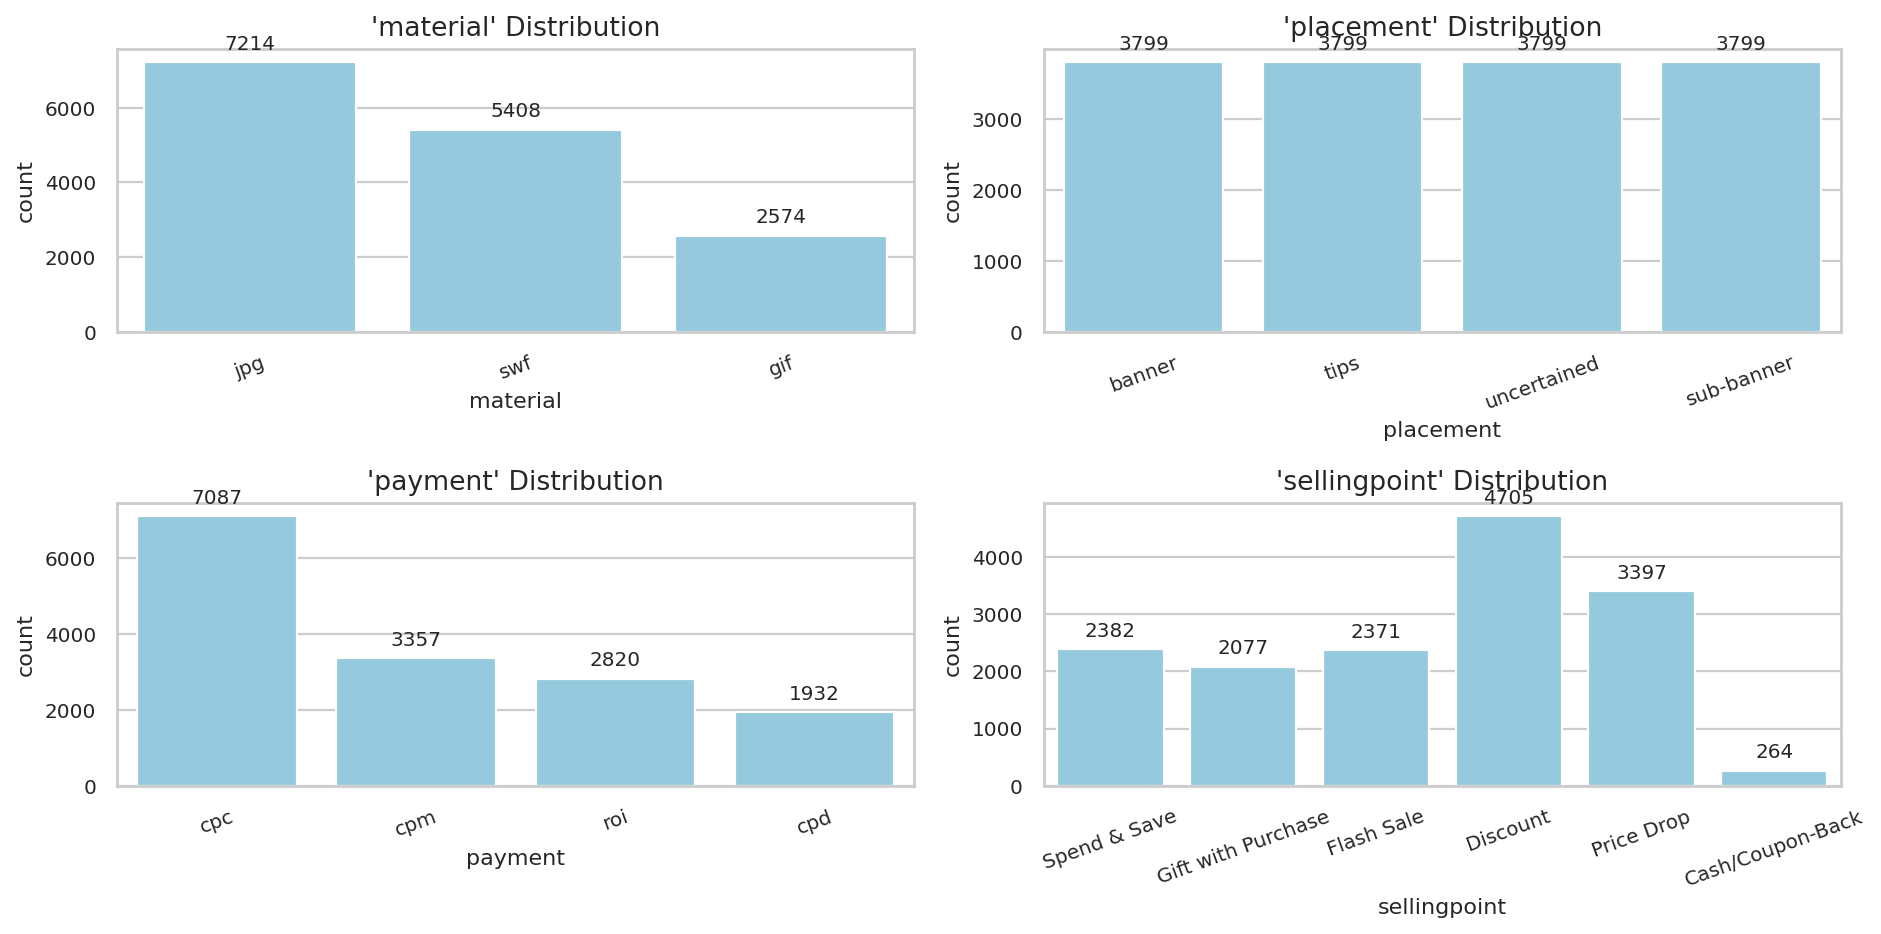

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# Create a more compact figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 6), dpi=160)
fig.subplots_adjust(wspace=0.3, hspace=0.6)  # Control spacing between subplots

# General plotting function
def plot_count(ax, column_name):
    sns.countplot(x=column_name, data=data_resampled, ax=ax, color='skyblue')
    ax.set_title(f"'{column_name}' Distribution", fontsize=12)
    ax.set_xlabel(column_name, fontsize=10)
    ax.set_ylabel("count", fontsize=10)
    ax.tick_params(axis='x', labelrotation=20, labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    # Add count labels on top of each bar
    for p in ax.patches:
        count = int(p.get_height())
        ax.annotate(str(count),
                    (p.get_x() + p.get_width() / 2., count),
                    ha='center', va='bottom',
                    fontsize=9, xytext=(0, 4), textcoords='offset points')

# Plot in sequence
plot_count(axes[0, 0], 'material')
plot_count(axes[0, 1], 'placement')
plot_count(axes[1, 0], 'payment')
plot_count(axes[1, 1], 'sellingpoint')

plt.tight_layout()
plt.show()


save the balanced dataset and download the dataset

In [ ]:

# Save the balanced dataset to a CSV file
data_resampled.to_csv('/content/balanced_output_smote.csv', index=False)
print("\nThe balanced dataset has been saved as '/content/balanced_output_smote.csv'")

# Automatically download the file in Colab
files.download('/content/balanced_output_smote.csv')



The balanced dataset has been saved as '/content/balanced_output_smote.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>